Predicting customer churn is critical for telecommunication companies to be able to effectively retain customers. It is more costly to acquire new customers than to retain existing ones. 

In this notebook, we build a model to predict how likely a customer will churn by analyzing its characteristics:
1. Demographic information
2. Account information
3. Services information.

The objective is to obtain a data-driven solution that will allow us to reduce churn rate and, as a consequence, to increase customer satisfaction and corporation revenue.

In [75]:
# Importing all the necessary libraries
import numpy as np
import pandas as pd
from collections import Counter
from datetime import datetime
from scipy.stats import t
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, IsolationForest, StackingRegressor

import seaborn as sns
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet
import xgboost
from xgboost import plot_importance, XGBClassifier
import time
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedKFold
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, auc, roc_curve, classification_report,mutual_info_score, confusion_matrix, roc_auc_score, precision_score, f1_score, roc_curve, plot_confusion_matrix,plot_roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import math
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import DBSCAN

import optuna
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)


import plotly 
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import shap 
import missingno as msno

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from collections import Counter

from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping

In [2]:
df =  pd.read_csv('Telco-Customer-Churn.csv')
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7010 entries, 0 to 7009
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7010 non-null   object 
 1   SeniorCitizen     7010 non-null   int64  
 2   Partner           7010 non-null   object 
 3   Dependents        7010 non-null   object 
 4   tenure            7010 non-null   int64  
 5   PhoneService      7010 non-null   object 
 6   MultipleLines     7010 non-null   object 
 7   InternetService   7010 non-null   object 
 8   OnlineSecurity    7010 non-null   object 
 9   OnlineBackup      7010 non-null   object 
 10  DeviceProtection  7010 non-null   object 
 11  TechSupport       7010 non-null   object 
 12  StreamingTV       7010 non-null   object 
 13  StreamingMovies   7010 non-null   object 
 14  Contract          7010 non-null   object 
 15  PaperlessBilling  7010 non-null   object 
 16  PaymentMethod     7010 non-null   object 


As shown above, the dataset contains 19 independent variables, which can be classified into 3 groups

##### (1) Demographic Information
- gender: Whether the client is a female or a male (Female, Male).
- SeniorCitizen: Whether the client is a senior citizen or not ( 0, 1).
- Partner: Whether the client has a partner or not (Yes, No).
- Dependents: Whether the client has dependents or not (Yes, No).

##### (2) Customer Account Information
- tenure: how long they’ve been a customer.
- Contract: customer’s current contract type (Month-to-Month, One year, Two year).
- PaperlessBilling: Whether the client has paperless billing or not (Yes, No).
- PaymentMethod: The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit Card (automatic)).
- MontlyCharges: The amount charged to the customer monthly (Multiple different numeric values).
- TotalCharges: The total amount charged to the customer (Multiple different numeric values).

##### (3) Services Information
- PhoneService: Whether the client has a phone service or not (Yes, No).
- MultipleLines: Whether the client has multiple lines or not (No phone service, No, Yes).
- InternetServices: Whether the client is subscribed to Internet service with the company (DSL, Fiber optic, No)
- OnlineSecurity: Whether the client has online security or not (No internet service, No, Yes).
- OnlineBackup: Whether the client has online backup or not (No internet service, No, Yes).
- DeviceProtection: Whether the client has device protection or not (No internet service, No, Yes).
- TechSupport: Whether the client has tech support or not (No internet service, No, Yes).
- StreamingTV: Whether the client has streaming TV or not (No internet service, No, Yes).
- StreamingMovies: Whether the client has streaming movies or not (No internet service, No, Yes).

##  Exploratory Data Analysis and Data Cleaning

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


No missing values, but TotalCharges was wrongly detected as an object type. 

In [6]:
# use the argument errors='coerce' to skip those cases and replace them with a NaN.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')

In [7]:
# null observations of the TotalCharges column
df[df['TotalCharges'].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


These observations have also a tenure of 0, even though MontlyCharges is not null for these entries. This information appeared to be contradictory, and therefore, we decide to remove those observations from the data set.

In [8]:
# drop observations with null values
df.dropna(inplace=True)

In [9]:
# Remove customerId column
df.drop(columns='customerID', inplace=True)

##### Payment method denominations
As shown below, some payment method denominations contain in parenthesis the word automatic. These denominations are too long to be used as tick labels in further visualizations. Therefore, we remove this clarification in parenthesis from the entries of the PaymentMethod column.

In [10]:
# unique elements of the PaymentMethod column
df.PaymentMethod.unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [11]:
# remove (automatic) from payment method names
df['PaymentMethod'] = df['PaymentMethod'].str.replace(' (automatic)', '', regex=False)

In [12]:
df.PaymentMethod.unique()

array(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card'],
      dtype=object)

## Data Clearning

### Outlier

1. Hypothesis Testing(GRUBBS TEST) Ho: There are no outliers in the data set H1: There is exactly one outlier in the data set 
2. Z-score method
3. Robust Z-score
4. I.Q.R method
5. Winsorization method(Percentile Capping)
6. DBSCAN Clustering
7. Isolation Forest
8. Visualizing the dat

In [13]:
# GRUBBS TEST
def grubbs_test(x):
    n = len(x)
    mean_x = np.mean(x)
    sd_x = np.std(x)
    numerator = max(abs(x-mean_x))
    g_calculated = numerator/sd_x
    print("Grubbs Calculated Value:",g_calculated)
    t_value = t.ppf(1 - 0.05 / (2 * n), n - 2)
    g_critical = ((n - 1) * np.sqrt(np.square(t_value))) / (np.sqrt(n) * np.sqrt(n - 2 + np.square(t_value)))
    print("Grubbs Critical Value:",g_critical)
    if g_critical > g_calculated:
        print("From grubbs_test we observe that calculated value is lesser than critical value, Accept null hypothesis and conclude that there is no outliers\n")
    else:
        print("From grubbs_test we observe that calculated value is greater than critical value, Reject null hypothesis and conclude that there is an outliers\n")

# Z-score method        
def Zscore_outlier(df):
    m = np.mean(df)
    sd = np.std(df)
    for i in df: 
        z = (i-m)/sd
        if np.abs(z) > 3: 
            out.append(i)
    print("Outliers:",out)
    
#ROBUST Z-SCORE
def ZRscore_outlier(df):
    med = np.median(df)
    ma = stats.median_absolute_deviation(df)
    for i in df: 
        z = (0.6745*(i-med))/ (np.median(ma))
        if np.abs(z) > 3: 
            out.append(i)
    print("Outliers:",out)
    
# IQR METHOD
out=[]
def iqr_outliers(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    for i in df:
        if i > Upper_tail or i < Lower_tail:
            out.append(i)
    print("Outliers:",out)

#WINSORIZATION METHOD(PERCENTILE CAPPING)
def Winsorization_outliers(df):
    q1 = np.percentile(df , 1)
    q3 = np.percentile(df , 99)
    for i in df:
        if i > q3 or i < q1:
            out.append(i)
    print("Outliers:",out)

# DBSCAN (DENSITY-BASED SPATIAL CLUSTERING OF APPLICATIONS WITH NOISE)
def DB_outliers(df):
    outlier_detection = DBSCAN(eps = 2, metric='euclidean', min_samples = 5)
    clusters = outlier_detection.fit_predict(df.values.reshape(-1,1))
    data = pd.DataFrame()
    data['cluster'] = clusters
    print(data['cluster'].value_counts().sort_values(ascending=False))

# ISOLATION FOREST
def Iso_outliers(df):
    iso = IsolationForest(random_state = 1, contamination= 'auto')
    preds = iso.fit_predict(df.values.reshape(-1,1))
    data = pd.DataFrame()
    data['cluster'] = preds
    print(data['cluster'].value_counts().sort_values(ascending=False))

In [14]:
numeric_variables = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [15]:
for col in numeric_variables:
    grubbs_test(df[col])
    # Iso_outliers(df[col])

Grubbs Calculated Value: 1.6125732136881465
Grubbs Critical Value: 4.4872995984066515
From grubbs_test we observe that calculated value is lesser than critical value, Accept null hypothesis and conclude that there is no outliers

Grubbs Calculated Value: 1.7933814803098407
Grubbs Critical Value: 4.4872995984066515
From grubbs_test we observe that calculated value is lesser than critical value, Accept null hypothesis and conclude that there is no outliers

Grubbs Calculated Value: 2.824261363345723
Grubbs Critical Value: 4.4872995984066515
From grubbs_test we observe that calculated value is lesser than critical value, Accept null hypothesis and conclude that there is no outliers



In [16]:
def drop_outliers(df, field_name):
    iqr = 1.5 * (np.percentile(df[field_name], 75) - np.percentile(df[field_name], 25))
    df.drop(df[df[field_name] > (iqr + np.percentile(df[field_name], 75))].index, inplace=True)
    df.drop(df[df[field_name] < (np.percentile(df[field_name], 25) - iqr)].index, inplace=True)

In [17]:
# sns.boxplot(df['tenure'])
# drop_outliers(df, 'tenure')
# sns.boxplot(train['Cost of Living Index'])
# plt.title("Box Plot after outlier removing")
# plt.show()

### Duplication

In [18]:
df.duplicated().sum()

22

In [19]:
#delete the duplicate data and maintain the first show-up data
df.drop_duplicates(inplace=True)

In [20]:
#reindex
df = df.reset_index(drop=True)

In [22]:
df.shape

(7010, 20)

### Missing

In [23]:
def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

missing(df)

,Missing_Number,Missing_Percent
gender,0,0.0
SeniorCitizen,0,0.0
TotalCharges,0,0.0
MonthlyCharges,0,0.0
PaymentMethod,0,0.0
PaperlessBilling,0,0.0
Contract,0,0.0
StreamingMovies,0,0.0
StreamingTV,0,0.0
TechSupport,0,0.0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7010 entries, 0 to 7009
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7010 non-null   object 
 1   SeniorCitizen     7010 non-null   int64  
 2   Partner           7010 non-null   object 
 3   Dependents        7010 non-null   object 
 4   tenure            7010 non-null   int64  
 5   PhoneService      7010 non-null   object 
 6   MultipleLines     7010 non-null   object 
 7   InternetService   7010 non-null   object 
 8   OnlineSecurity    7010 non-null   object 
 9   OnlineBackup      7010 non-null   object 
 10  DeviceProtection  7010 non-null   object 
 11  TechSupport       7010 non-null   object 
 12  StreamingTV       7010 non-null   object 
 13  StreamingMovies   7010 non-null   object 
 14  Contract          7010 non-null   object 
 15  PaperlessBilling  7010 non-null   object 
 16  PaymentMethod     7010 non-null   object 


## Data Visualization

In [26]:
# Target Variable
prop_response = df['Churn'].value_counts(normalize=True)
prop_response

No     0.735093
Yes    0.264907
Name: Churn, dtype: float64

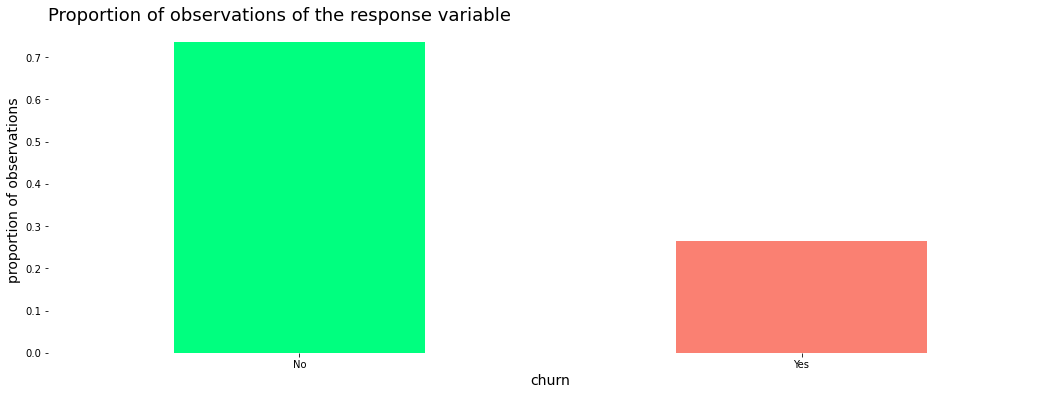

In [27]:
fig, ax = plt.subplots(figsize=(18, 6)) 
prop_response.plot(kind='bar',color=['springgreen','salmon'])
ax.set_title('Proportion of observations of the response variable',fontsize=18, loc='left')
ax.set_xlabel('churn',fontsize=14)
ax.set_ylabel('proportion of observations',fontsize=14)
ax.tick_params(rotation='auto')
# eliminate the frame from the plot
spine_names = ('top', 'right', 'bottom', 'left')
for spine_name in spine_names:
    ax.spines[spine_name].set_visible(False)
plt.show()

As shown obove, this is an imbalanced data 

In [30]:
le = LabelEncoder()
df['Churn']=le.fit_transform(df['Churn'])

In [32]:
numerical= df.select_dtypes('number').columns
categorical = df.select_dtypes('object').columns
print(f'Numerical Columns:  {df[numerical].columns}')
print('\n')
print(f'Categorical Columns: {df[categorical].columns}')

Numerical Columns:  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn'], dtype='object')


Categorical Columns: Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')


In [33]:
df[numerical].describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
count,7010.000000,7010.000000,7010.000000,7010.000000,7010.000000
mean,0.162767,32.520399,64.888666,2290.353388,0.264907
std,0.369180,24.520441,30.064769,2266.820832,0.441315
min,0.000000,1.000000,18.250000,18.800000,0.000000
25%,0.000000,9.000000,35.750000,408.312500,0.000000
50%,0.000000,29.000000,70.400000,1403.875000,0.000000
75%,0.000000,56.000000,89.900000,3807.837500,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000


In [34]:
df[['tenure', 'MonthlyCharges', 'TotalCharges']].iplot(kind='histogram',subplots=True,bins=50)

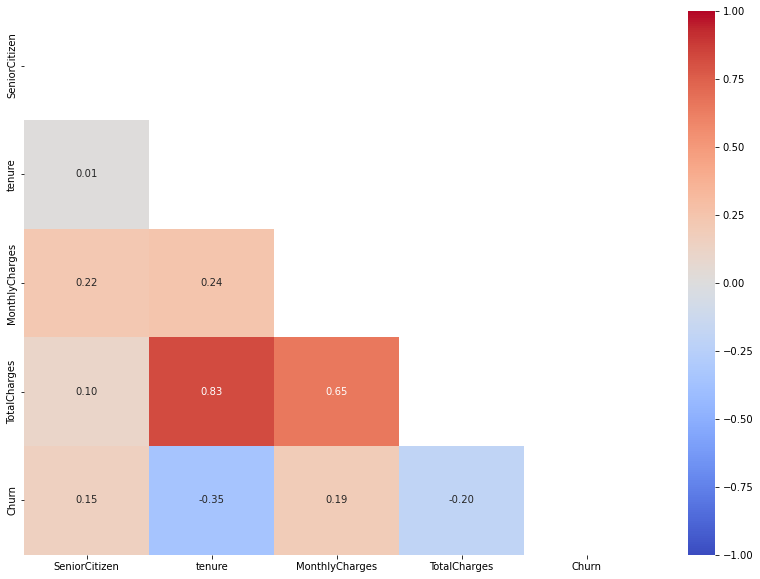

In [37]:
matrix = np.triu(df[numerical].corr())
fig, ax = plt.subplots(figsize=(14,10)) 
sns.heatmap (df[numerical].corr(), annot=True, fmt= '.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm',mask=matrix, ax=ax);
plt.show()

- Based on the matrix, we can observe weak level correlation between the numerical features and the target variable
- There is strong correlation between tenure and total charges.
- Being senior citizen and increasing monthly charges have a positive correlation with the churn.
- Senior citizen more likely churn than younger customers.
- Customer with higher monthly charges also more likely churn than lesser monthly charges customers.
- Being long term with the company, customer less likely churn than customer with lesser time with the company.
- Total charges has negative correlation with the churn.

In [38]:
df[categorical].nunique()

gender              2
Partner             2
Dependents          2
PhoneService        2
MultipleLines       3
InternetService     3
OnlineSecurity      3
OnlineBackup        3
DeviceProtection    3
TechSupport         3
StreamingTV         3
StreamingMovies     3
Contract            3
PaperlessBilling    2
PaymentMethod       4
dtype: int64

In [39]:
for feature in df[categorical]:
        print(f'{feature}: {df[feature].unique()}')

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer' 'Credit card']


- We can see that No internet service is repeating several times in the features and in this problem at hand, it gives same meaning as No
- So we can change them to No and then features will have two unique values,
- Also MultipleLines has No phone service option, which in this problem gives same meaning as No so we can change it to No and do the same thing for this feature.
- Lets'start with the bivariate analysis and on the way we will make the relevant changes.

In [47]:
change_columns = ['MultipleLines','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
for col in change_columns:
    df[col] = df[col].str.replace('No internet service', 'No', regex=False)
    df[col] = df[col].str.replace('No phone service', 'No', regex=False)

In [49]:
# normalized stacked bar plot 
def percentage_stacked_plot(data, columns_to_plot, super_title, target):
    number_of_columns = 2
    number_of_rows = math.ceil(len(columns_to_plot)/2)
    # create a figure
    fig = plt.figure(figsize=(12, 5 * number_of_rows)) 
    fig.suptitle(super_title, fontsize=22,  y=.95)
 
    # loop to each column name to create a subplot
    for index, column in enumerate(columns_to_plot, 1):
        # create the subplot
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)
      
        # calculate the percentage of observations of the response variable for each group of the independent variable
        # 100% stacked bar plot
        sns.histplot(data=data,x=column , hue=target, multiple="fill", stat="percent",discrete=True, shrink=.5)
        # set title and labels
        ax.set_title('Proportion of observations by ' + column,fontsize=16, loc='left')
        ax.tick_params(rotation='auto')

        # eliminate the frame from the plot
        spine_names = ('top', 'right', 'bottom', 'left')
        for spine_name in spine_names:
            ax.spines[spine_name].set_visible(False)

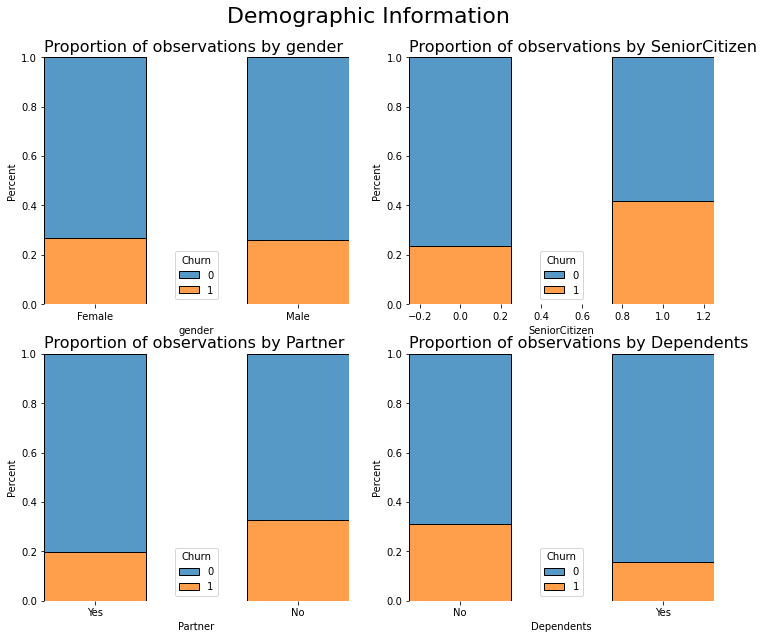

In [50]:

# demographic column names
demographic_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

# stacked plot of demographic columns
percentage_stacked_plot(df, demographic_columns, 'Demographic Information','Churn')

As shown above, each bar is a category of the independent variable, and it is subdivided to show the proportion of each response class (No and Yes).

We can extract the following conclusions by analyzing demographic attributes:

- The churn rate of senior citizens is almost double that of young citizens.
- We do not expect gender to have significant predictive power. A similar percentage of churn is shown both when a customer is a man or a woman.
- Customers with a partner churn less than customers with no partner.

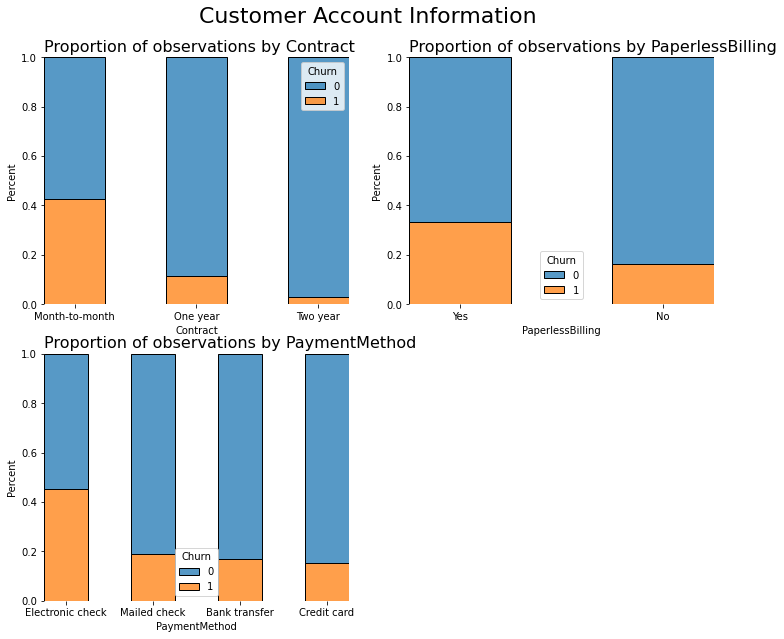

In [51]:
# customer account column names
account_columns = ['Contract', 'PaperlessBilling', 'PaymentMethod']

# stacked plot of customer account columns
percentage_stacked_plot(df, account_columns, 'Customer Account Information','Churn')

We can extract the following conclusions by analyzing customer account attributes:

- Customers with month-to-month contracts have higher churn rates compared to clients with yearly contracts.
- Customers who opted for an electronic check as paying method are more likely to leave the company.
- Customers subscribed to paperless billing churn more than those who are not subscribed.

In [52]:
def histogram_plots(data, columns_to_plot, super_title, target):
    # set number of rows and number of columns
    number_of_columns = 2
    number_of_rows = math.ceil(len(columns_to_plot)/2)

    # create a figure
    fig = plt.figure(figsize=(12, 5 * number_of_rows)) 
    fig.suptitle(super_title, fontsize=22,  y=.95) 

    # loop to each demographic column name to create a subplot
    for index, column in enumerate(columns_to_plot, 1):
        # create the subplot
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)
        # histograms for each class (normalized histogram)
        sns.histplot(x=column, hue=target, data=df, stat="density", shrink=.5,common_norm=False,multiple ='layer',bins=10)
        # set title and labels
        ax.set_title('Distribution of ' + column + ' by churn',fontsize=16, loc='left')
        ax.tick_params(rotation='auto')
        # eliminate the frame from the plot
        spine_names = ('top', 'right', 'bottom', 'left')
        for spine_name in spine_names:
            ax.spines[spine_name].set_visible(False)

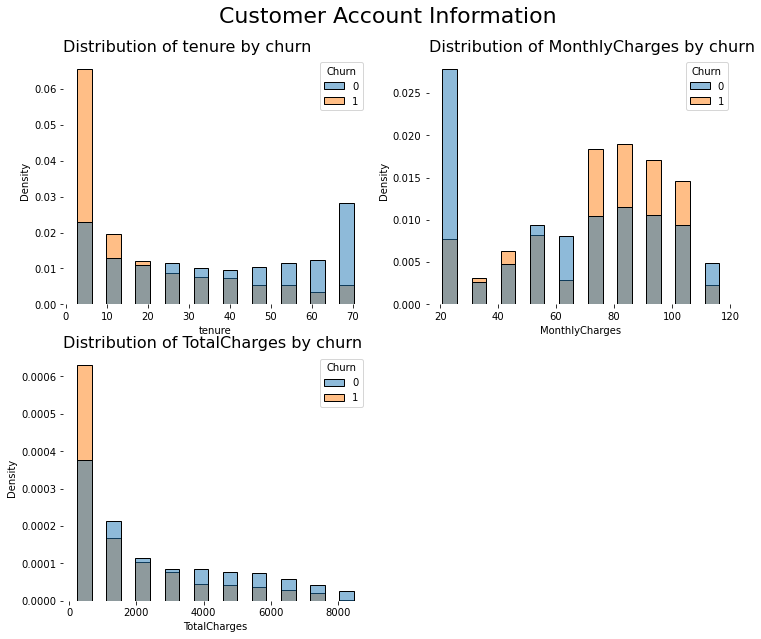

In [53]:
         
# customer account column names
account_columns_numeric = ['tenure', 'MonthlyCharges', 'TotalCharges']
# histogram of costumer account columns 
histogram_plots(df, account_columns_numeric, 'Customer Account Information', 'Churn')

- The churn rate tends to be larger when monthly charges are high.
- New customers (low tenure) are more likely to churn.
- Clients with high total charges are less likely to leave the company.

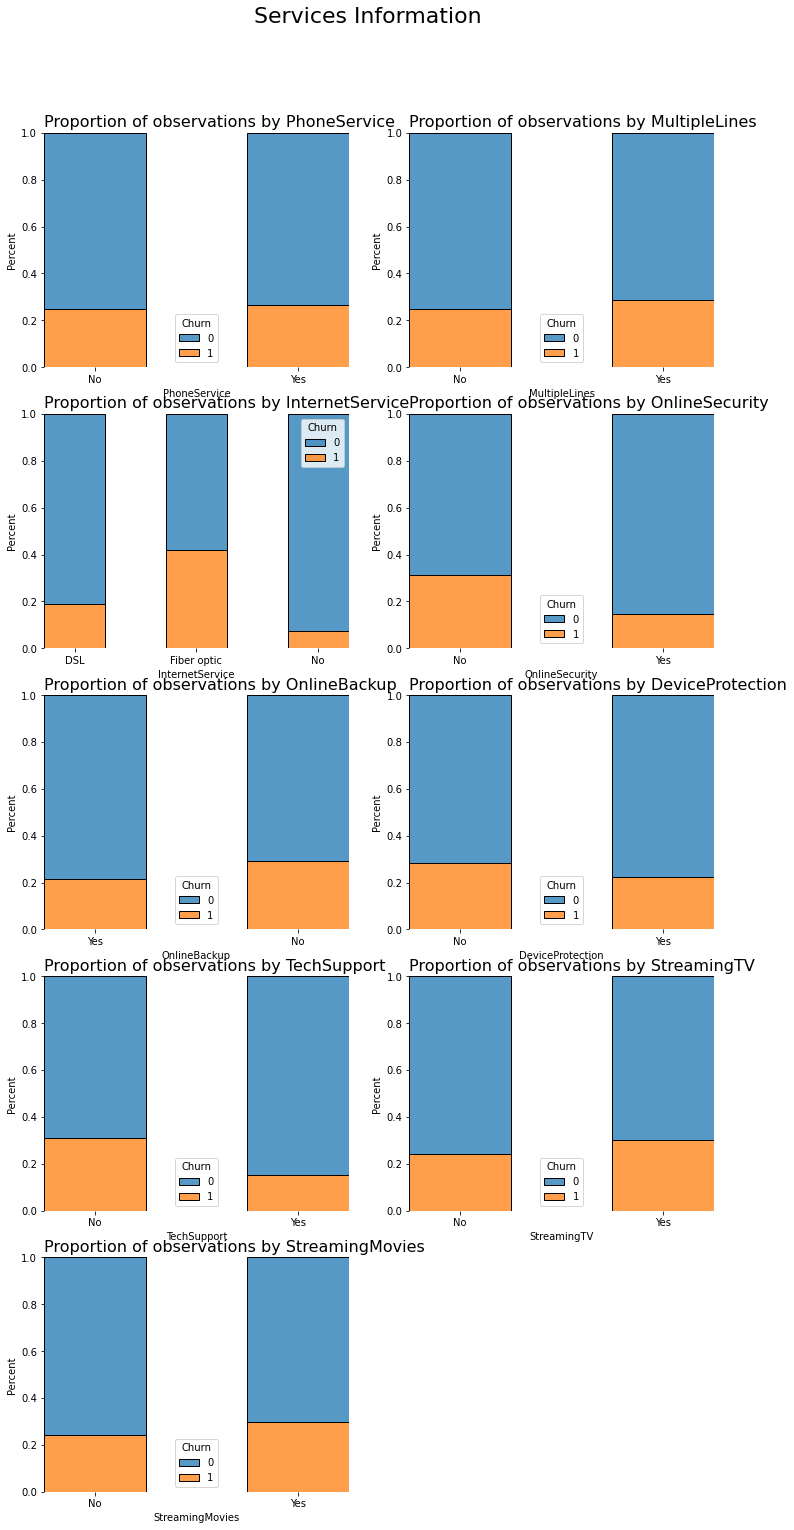

In [54]:
# services column names
services_columns = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                   'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# stacked plot of services columns
percentage_stacked_plot(df, services_columns, 'Services Information', 'Churn')

- We do not expect phone attributes (PhoneService and MultipleLines) to have significant predictive power. The percentage of churn for all classes in both independent variables is nearly the same.
- Clients with online security churn less than those without it.
- Customers with no tech support tend to churn more often than those with tech support.

By looking at the plots above, we can identify the most relevant attributes for detecting churn. We expect these attributes to be discriminative in our future models.

## Feature importance

Mutual information — analysis of linear and nonlinear relationships

Mutual information measures the mutual dependency between two variables based on entropy estimations. In machine learning, we are interested in evaluating the degree of dependency between each independent variable and the response variable. Higher values of mutual information show a higher degree of dependency which indicates that the independent variable will be useful for predicting the target.

The mutual information extends the notion of correlation to nonlinear relationships since, unlike Pearson’s correlation coefficient, this method is able to detect not only linear relationships but also nonlinear ones.

In [58]:
def compute_mutual_information(cat):
    return mutual_info_score(cat, df.Churn)
# select categorial variables excluding the response variable 
categorical_variables = df.select_dtypes(include=object)
# compute the mutual information score between each categorical variable and the target
feature_importance = categorical_variables.apply(compute_mutual_information).sort_values(ascending=False)
print(feature_importance)

Contract            0.098031
InternetService     0.055676
PaymentMethod       0.044250
PaperlessBilling    0.018934
OnlineSecurity      0.015753
TechSupport         0.014477
Dependents          0.014131
Partner             0.011180
OnlineBackup        0.003366
DeviceProtection    0.002148
StreamingTV         0.002097
StreamingMovies     0.001947
MultipleLines       0.000874
PhoneService        0.000062
gender              0.000038
dtype: float64


Mutual information allows us not only to better understand our data but also to identify the predictor variables that are completely independent of the target. 

As shown above, gender, PhoneService, and MultipleLines have a mutual information score really close to 0, meaning those variables do not have a strong relationship with the target. This information is in line with the conclusions we have previously drawn by visualizing the data. 

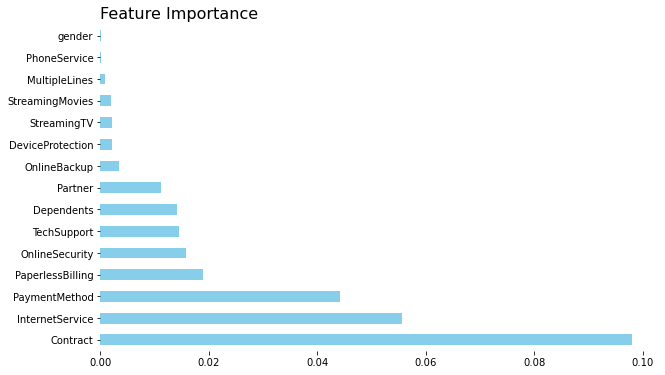

In [59]:
plt.figure(figsize=(10,6))
ax = feature_importance.plot.barh(color='skyblue')
spine_names = ('top', 'right', 'bottom', 'left')
for spine_name in spine_names:
     ax.spines[spine_name].set_visible(False)
ax.set_title('Feature Importance',fontsize=16, loc='left')
plt.show()

## Feature Engineering

### One-Hot Encoding

In [60]:
df_transformed = df.copy()
# label encoding (binary variables)
label_encoding_columns = ['gender', 'Partner', 'Dependents', 'PaperlessBilling', 'PhoneService', 'Churn']

for col in label_encoding_columns:
    if col == 'gender':
        df_transformed[col] = df_transformed[col].map({'Female':1, 'Male': 0})
    else:
        df_transformed[col] = df_transformed[col].map({'Yes': 1, 'No': 0})

In [61]:
one_hot_encoding_columns = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                            'TechSupport', 'StreamingTV',  'StreamingMovies', 'Contract', 'PaymentMethod']
df_transformed = pd.get_dummies(df_transformed, columns=one_hot_encoding_columns, drop_first=True)

### Feature Scaling

In [62]:
# min-max normalization (numeric variables)
min_max_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
for col in min_max_columns:
    min_value = df_transformed[col].min()
    max_value = df_transformed[col].max()
    df_transformed[col] = (df_transformed[col]-min_value)/(max_value-min_value)

In [63]:
df_transformed.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card,PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,0.000000,0,1,0.115423,0.001275,NaN,...,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0.464789,1,0,0.385075,0.215867,NaN,...,0,1,0,0,0,1,0,0,0,1
2,0,0,0,0,0.014085,1,1,0.354229,0.010310,NaN,...,1,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0.619718,0,0,0.239303,0.210241,NaN,...,0,1,1,0,0,1,0,0,0,0
4,1,0,0,0,0.014085,1,1,0.521891,0.015330,NaN,...,0,0,0,0,0,0,0,0,1,0


## Setting a baseline

In machine learning, we often use a simple classifier called baseline to evaluate the performance of a model. In this classification problem, the rate of customers that did not churn (most frequent class) can be used as a baseline to evaluate the quality of the models generated. These models should outperform the baseline capabilities to be considered for future predictions.

## Modeling

In [64]:
X = df_transformed.drop(columns='Churn')
y = df.Churn
print(X.columns)
print(y.name)

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'MultipleLines_Yes', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_Yes', 'OnlineBackup_Yes',
       'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card', 'PaymentMethod_Electronic check',
       'PaymentMethod_Mailed check'],
      dtype='object')
Churn


In [65]:
# split the data in training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=40, shuffle=True)

In this project, we compare 6 different algorithms, all of them already implemented in Scikit-Learn.

- Dummy classifier (baseline)
- K Nearest Neighbours
- Logistic Regression
- Support Vector Machines
- Random Forest
- Gradiente Boosting

In [66]:
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [67]:
def create_models(seed = 2022):
    models = []
    models.append(('dummy_classifier', DummyClassifier(random_state = seed, strategy = 'most_frequent')))
    models.append(('k_nearest_neighbors', KNeighborsClassifier()))
    models.append(('logistic_regression', LogisticRegression(random_state=seed)))
    models.append(('support_vector_machines', SVC(random_state=seed)))
    models.append(('random_forest', RandomForestClassifier(random_state=seed)))
    models.append(('gradient_boosting', GradientBoostingClassifier(random_state=seed)))
    return models   

In [68]:
models = create_models()

In [69]:
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    results.append(accuracy)
    names.append(name)
    print('Classifier:{}, Accuracy: {}'.format(name, accuracy))

Classifier:dummy_classifier, Accuracy: 0.7370222475755848
Classifier:k_nearest_neighbors, Accuracy: 0.7621220764403879
Classifier:logistic_regression, Accuracy: 0.8111808328579578
Classifier:support_vector_machines, Accuracy: 0.8054763262977752
Classifier:random_forest, Accuracy: 0.7866514546491729
Classifier:gradient_boosting, Accuracy: 0.8111808328579578


## Hyperparameter tuning

In [ ]:
grid_parameters = {'n_estimators': [80, 90, 100, 110, 115, 120],
                   'max_depth': [3, 4, 5, 6],
                   'max_features': [None, 'auto', 'sqrt', 'log2'], 
                   'min_samples_split': [2, 3, 4, 5]}


# define the RandomizedSearchCV class for trying different parameter combinations
random_search = RandomizedSearchCV(estimator=GradientBoostingClassifier(),
                                   param_distributions=grid_parameters,
                                   cv=5,
                                   n_iter=150,
                                   n_jobs=-1)

# fitting the model for random search 
random_search.fit(X_train, y_train)

# print best parameter after tuning
print(random_search.best_params_)

In [ ]:
# make the predictions
random_search_predictions = random_search.predict(X_test)

# construct the confusion matrix
confusion_matrix = confusion_matrix(y_test, random_search_predictions)

# visualize the confusion matrix
confusion_matrix

In [ ]:
print(classification_report(y_test, random_search_predictions))

In [ ]:
model_rf = RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "auto",
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)
print (accuracy_score(y_test, prediction_test))

## XGBoost & LightGBM & Catboost - Imbalanced Data

### CatBoost

In [72]:
accuracy= []
recall =[]
roc_auc= []
precision = []

model_names =[]

categorical_features_indices = np.where(X.dtypes != float)[0]

catboost_base = CatBoostClassifier(verbose=False,random_state=0)

catboost_base.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test))
y_pred = catboost_base.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

model_names = ['Catboost_default']
result_df1 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df1

,Accuracy,Recall,Roc_Auc,Precision
Catboost_default,0.8152,0.564,0.7344,0.6789


In [81]:
catboost_base.classes_

array([0, 1], dtype=int64)

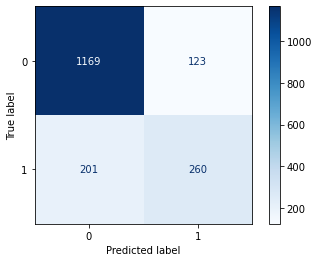

In [89]:
cm = confusion_matrix(y_test, y_pred, labels=catboost_base.classes_)
disp =ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=catboost_base.classes_).plot(cmap=plt.cm.Blues);
plt.show()

- By using deafult value of scale_pos_weight, CatBoost correctly predicted almost half of the churned customer
- But model couldn't be able to correctly predict the other half.

#### CatBoost (with adjusted Scale_Pos_Weight = 3) Deals With Imbalanced Data

In [91]:
accuracy= []
recall =[]
roc_auc= []
precision = []

catboost = CatBoostClassifier(verbose=False,random_state=0,scale_pos_weight=3)

catboost.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test))
y_pred = catboost.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

model_names = ['Catboost_adjusted_weight_3']
result_df2 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df2

,Accuracy,Recall,Roc_Auc,Precision
Catboost_adjusted_weight_3,0.741,0.8243,0.7678,0.5046


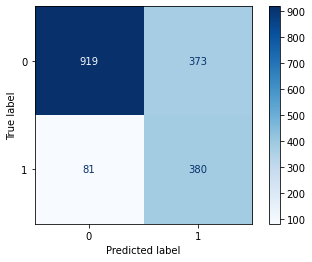

In [92]:
cm = confusion_matrix(y_test, y_pred, labels=catboost.classes_)
disp =ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=catboost.classes_).plot(cmap=plt.cm.Blues);
plt.show()

#### CatBoost (with adjusted Scale_Pos_Weight = 5) Deals With Imbalanced Data

In [93]:
accuracy= []
recall =[]
roc_auc= []
precision = []
catboost_5 = CatBoostClassifier(verbose=False,random_state=0,scale_pos_weight=5)

catboost_5.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test))
y_pred = catboost_5.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

model_names = ['Catboost_adjusted_weight_5']
result_df3 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df3

,Accuracy,Recall,Roc_Auc,Precision
Catboost_adjusted_weight_5,0.6805,0.9024,0.7519,0.4468


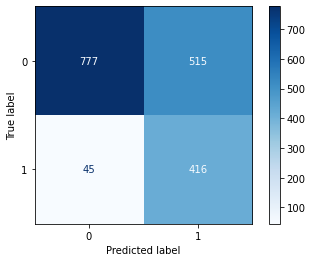

In [94]:
cm = confusion_matrix(y_test, y_pred, labels=catboost_5.classes_)
disp =ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=catboost_5.classes_).plot(cmap=plt.cm.Blues);
plt.show()

#### SHAP Summary Plot - CatBoost (with adjusted Scale_Pos_Weight = 5 )

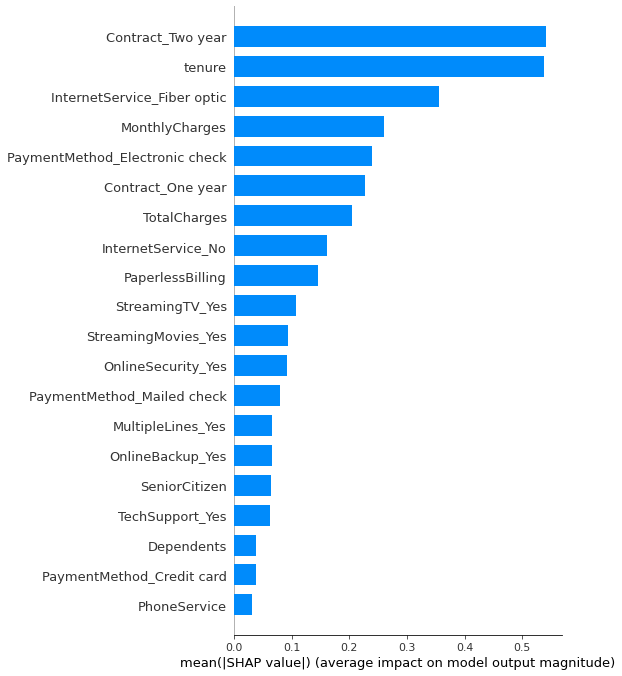

In [97]:
explainercat = shap.TreeExplainer(catboost_5)
shap_values_cat_test = explainercat.shap_values(X_test)
shap_values_cat_train = explainercat.shap_values(X_train)
shap.summary_plot(shap_values_cat_train, X_train, plot_type="bar")

### XGBoost 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[13:04:13] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[13:04:13] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[13:04:13] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


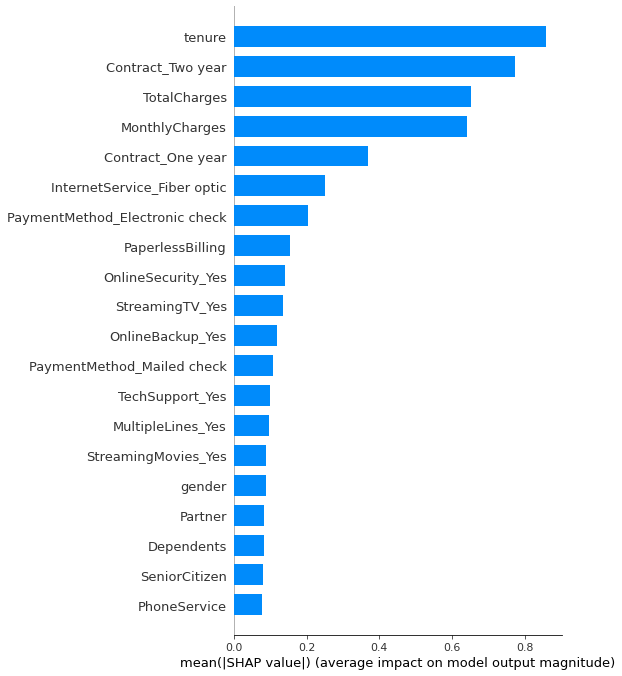

In [98]:
accuracy= []
recall =[]
roc_auc= []
precision = []
xgbc_base = XGBClassifier(random_state=0)
xgbc_base.fit(X_train, y_train)
y_pred = xgbc_base.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))
model_names = ['XGBoost_Default']
result_df4 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)

accuracy= []
recall =[]
roc_auc= []
precision = []
xgbc_3 = XGBClassifier(random_state=0,scale_pos_weight=3)
xgbc_3.fit(X_train, y_train)
y_pred = xgbc_3.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))
model_names = ['XGBoost_adjusted_weight_3']
result_df5 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)

accuracy= []
recall =[]
roc_auc= []
precision = []
xgbc_5 = XGBClassifier(random_state=0,scale_pos_weight=5)
xgbc_5.fit(X_train, y_train)
y_pred = xgbc_5.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))
model_names = ['XGBoost_adjusted_weight_5']
result_df6 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)

explainerxgbc = shap.TreeExplainer(xgbc_5)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)
shap_values_XGBoost_train = explainerxgbc.shap_values(X_train)
shap.summary_plot(shap_values_XGBoost_train, X_train, plot_type="bar")

### Lightgbm

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


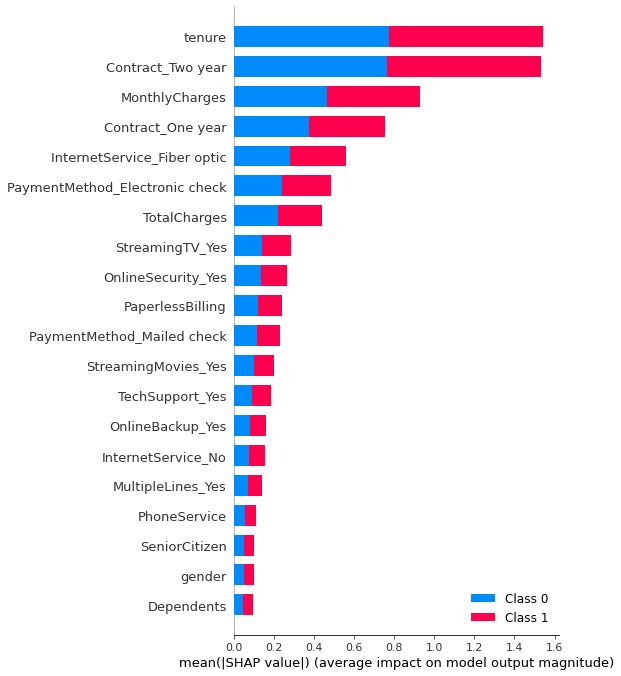

In [99]:
accuracy= []
recall =[]
roc_auc= []
precision = []
lgbmc_base=LGBMClassifier(random_state=0)
lgbmc_base.fit(X_train, y_train,categorical_feature = 'auto',eval_set=(X_test, y_test),feature_name='auto', verbose=0)
y_pred = lgbmc_base.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))
model_names = ['LightGBM_default']
result_df7 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)


accuracy= []
recall =[]
roc_auc= []
precision = []
lgbmc_3=LGBMClassifier(random_state=0,scale_pos_weight=3)
lgbmc_3.fit(X_train, y_train,categorical_feature = 'auto',eval_set=(X_test, y_test),feature_name='auto', verbose=0)
y_pred = lgbmc_3.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))
model_names = ['LightGBM_adjusted_weight_3']
result_df8 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)

accuracy= []
recall =[]
roc_auc= []
precision = []
lgbmc_5=LGBMClassifier(random_state=0,scale_pos_weight=5)
lgbmc_5.fit(X_train, y_train,categorical_feature = 'auto',eval_set=(X_test, y_test),feature_name='auto', verbose=0)
y_pred = lgbmc_5.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))
model_names = ['LightGBM_adjusted_weight_5']
result_df9 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)


explainerlgbmc = shap.TreeExplainer(lgbmc_5)
shap_values_LightGBM_test = explainerlgbmc.shap_values(X_test)
shap_values_LightGBM_train = explainerlgbmc.shap_values(X_train)
shap.summary_plot(shap_values_LightGBM_train, X_train, plot_type="bar")

In [100]:
result_final= pd.concat([result_df1,result_df2,result_df3,result_df4,result_df5,result_df6, result_df7,result_df8,result_df9],axis=0)
result_final

,Accuracy,Recall,Roc_Auc,Precision
Catboost_default,0.8152,0.5640,0.7344,0.6789
Catboost_adjusted_weight_3,0.7410,0.8243,0.7678,0.5046
Catboost_adjusted_weight_5,0.6805,0.9024,0.7519,0.4468
XGBoost_Default,0.7884,0.5640,0.7162,0.6047
XGBoost_adjusted_weight_3,0.7479,0.7050,0.7341,0.5151
XGBoost_adjusted_weight_5,0.7393,0.7570,0.7450,0.5029
LightGBM_default,0.7981,0.5531,0.7193,0.6328
LightGBM_adjusted_weight_3,0.7399,0.7701,0.7496,0.5035
LightGBM_adjusted_weight_5,0.7176,0.8438,0.7582,0.4791


In [101]:
result_final.sort_values(by=['Recall'], ascending=True,inplace=True)
fig = px.bar(result_final, x='Recall', y=result_final.index,title='Model Comparison',height=600,labels={'index':'MODELS'})
fig.show()